# Heteroskedasticity

Here's a [question from the Reddit statistics forum]().

> 

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/heterosked.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
np.random.seed(19)

In [4]:
xs = np.random.normal(10, 1, size=500)
xs.sort()

In [5]:
sigma = 1.3
ys = 0.5 * xs + np.random.normal(0, sigma, size=len(xs))

homosked = pd.DataFrame(dict(x=xs, y=ys))
homosked.corr()

,x,y
x,1.000000,0.386422
y,0.386422,1.000000


In [24]:
from scipy.interpolate import interp1d

def interpolate(xs, sigma_seq):
    return interp1d([6, 10, 14], sigma_seq)(xs)


sigmas = interpolate(xs, [0.4, 2.2, 4.0])
sigmas = interpolate(xs, [0.2, 1.8, 0.2])
np.mean(sigmas)

1.4838202633093243

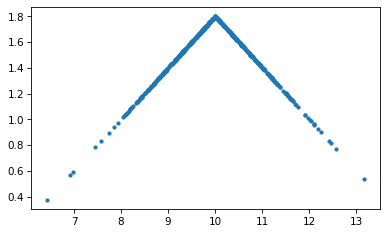

In [25]:
plt.plot(xs, sigmas, '.')

In [26]:
ys = 0.5 * xs + np.random.normal(0, sigmas)

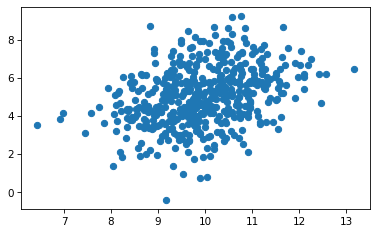

In [27]:
plt.plot(xs, ys, 'o')

In [28]:
from scipy.stats import linregress

res = linregress(xs, ys)
res._asdict()

{'slope': 0.5264550730938091,
 'intercept': -0.20682175339762576,
 'rvalue': 0.339552184483038,
 'pvalue': 5.868284655442166e-15,
 'stderr': 0.06534903628688365,
 'intercept_stderr': 0.6526252789345743}

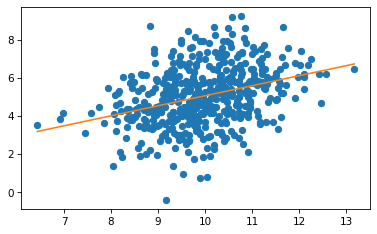

In [29]:
fys = res.intercept + res.slope * xs

plt.plot(xs, ys, 'o')
plt.plot(xs, fys)

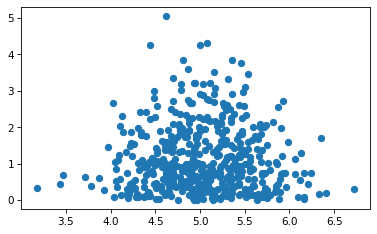

In [30]:
resid = ys - fys
plt.plot(fys, np.abs(resid), 'o')

In [31]:
res = linregress(fys, np.abs(resid))
res.slope

-0.02248112123132494

In [32]:
heterosked = pd.DataFrame(dict(x=xs, y=ys))
heterosked.corr()

,x,y
x,1.000000,0.339552
y,0.339552,1.000000


In [33]:
# Note: maybe boostrapping won't do it
# Maybe we have to simulate the data generating process


def resample_slope(df):
    resampled = df.sample(frac=1, replace=True)
    res = linregress(resampled.x, resampled.y)
    return res.slope

In [34]:
np.random.seed(17)
sample = [resample_slope(heterosked) for i in range(1001)]

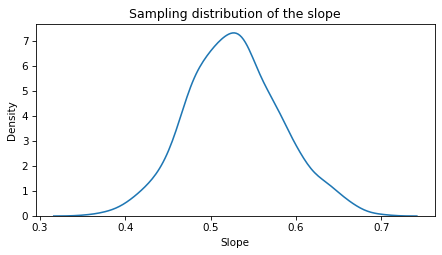

In [35]:
sns.kdeplot(sample)
decorate(xlabel='Slope',
         ylabel='Density',
         title='Sampling distribution of the slope')

In [36]:
np.std(sample)

0.05486319007993081

In [37]:
def resample_fit(df, xs):
    resampled = df.sample(frac=1, replace=True)
    res = linregress(resampled.x, resampled.y)
    fys = res.intercept + res.slope * xs
    return fys

In [38]:
def plot_percentile_fits(df, xs):
    fits = [resample_fit(heterosked, xs) for i in range(101)]
    low, high = np.percentile(np.array(fits), [5, 95], axis=0)
    plt.fill_between(xs, low, high, alpha=0.2)

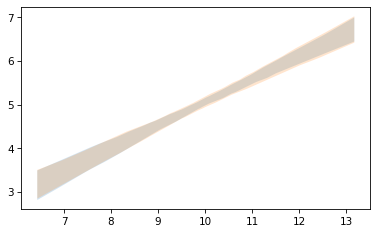

In [39]:
plot_percentile_fits(heterosked, xs)
plot_percentile_fits(homosked, xs)

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)